In [ ]:
!pip install ipython-autotime
!pip install tensorflow==2.1.0
!pip install nltk
!pip install shap
!pip install wordcloud

In [ ]:
import numpy as np
np.random.seed(1)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.metrics import roc_curve, roc_auc_score, auc, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold

import shap
from wordcloud import WordCloud

%load_ext autotime

tf.random.set_seed(1)
print(tf.__version__)
plt.style.use('ggplot')

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',filename=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure()
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if filename:
        plt.savefig(filename, dpi=500)
    plt.show()
    
def plot_roc_curve(ground_truth, predictions, filename=None):
    fpr, tpr, thr = roc_curve(y_true=ground_truth, y_score=predictions, drop_intermediate=False)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(15,10))
    lw = 2
    plt.plot(fpr, tpr,
             lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2,
         label='Chance', alpha=.8)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")
    if filename:
        plt.savefig(filename, dpi=500)
    plt.show()
    #return fpr, tpr, thr

def cross_validation_plot_roc_curve(ground_truth, predictions, filename=None):
    plt.figure(figsize=(15,10))
    i = 0
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    aucs = []
    for g, p in zip(ground_truth, predictions):
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_true = g, y_score = p, drop_intermediate=False)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.4f)' % (i, roc_auc))
        i += 1
    
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.4f $\pm$ %0.4f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")
    if filename:
        plt.savefig(filename, dpi=500)
    plt.show()
    return aucs
   

time: 115 ms


In [6]:
notes_filename = 'MIMICIII_sapsii_dataset_medical-notes.pickle'
notes = pd.read_pickle(notes_filename);
notes.sort_values(by=['subject_id', 'icu_time_hr'], ascending=[True, True], inplace=True)
print(notes['subject_id'].nunique())
notes.head(10)

21415


,subject_id,hadm_id,icustay_id,mort_icu,los,row_id,iserror,category,description,text,icu_time_hr,sapsii_prob
0,3,145834,211552,0,6.0646,768818,None,Radiology,CHEST (PORTABLE AP),[**2101-10-20**] 10:23 PM\n CHEST (PORTABLE AP...,3.0,0.918976
1,3,145834,211552,0,6.0646,768829,None,Radiology,CHEST (PORTABLE AP),[**2101-10-21**] 1:00 AM\n CHEST (PORTABLE AP)...,6.0,0.918976
2,3,145834,211552,0,6.0646,768834,None,Radiology,CHEST (PORTABLE AP),[**2101-10-21**] 6:10 AM\n CHEST (PORTABLE AP)...,11.0,0.918976
3,3,145834,211552,0,6.0646,1260684,None,Nursing/other,Report,Micu Progress Nursing Note:\n\nPatient arrived...,12.0,0.918976
4,3,145834,211552,0,6.0646,1260685,None,Nursing/other,Report,MICU NSG PROG NOTE: days\nRemains stable on hi...,19.0,0.918976
5,3,145834,211552,0,6.0646,768885,None,Radiology,CHEST (PORTABLE AP),[**2101-10-21**] 4:43 PM\n CHEST (PORTABLE AP)...,22.0,0.918976
6,3,145834,211552,0,6.0646,1260686,None,Nursing/other,Report,MICU NPN 3PM-11PM:\nNeuro: Pt is restless at t...,26.0,0.918976
7,3,145834,211552,0,6.0646,1260687,None,Nursing/other,Report,NPN addendum:\nOrder for additional NS bolus 5...,27.0,0.918976
8,3,145834,211552,0,6.0646,1260688,None,Nursing/other,Report,Resp. Care Note\nPt intubated and vented on se...,33.0,0.918976
9,3,145834,211552,0,6.0646,1260689,None,Nursing/other,Report,Micu Nursing Progress Note:\n\nNeuro: Remains ...,35.0,0.918976


time: 739 ms


Nursing/other      83147
Radiology          61096
Nursing            43790
Physician          27789
Respiratory         5728
General             1775
Nutrition           1549
Rehab Services       521
Social Work          501
Case Management      134
Consult               40
Pharmacy              12
Name: category, dtype: int64


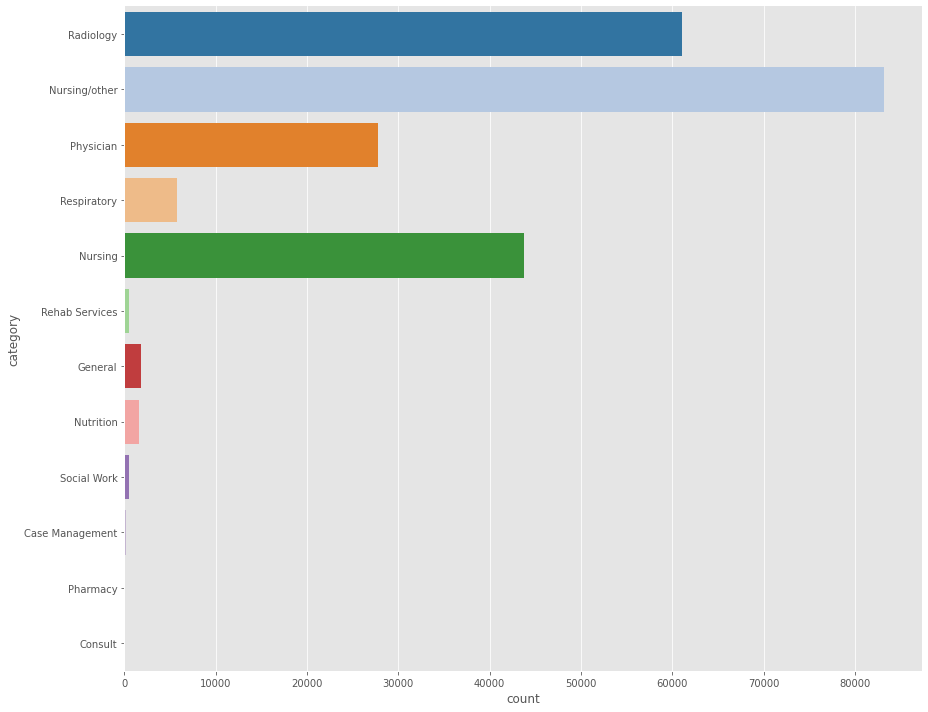

time: 5.22 s


In [7]:
sns.catplot(y='category', kind='count', palette="tab20", data=notes, height=10, aspect=1.3)
plt.tight_layout()
plt.savefig('note_distribution.png', dpi=500)
print(notes['category'].value_counts())

In [8]:
filtered_notes = notes[notes.category.isin(['Nursing/other', 'Radiology', 'Nursing', 'Physician'])]#.sample(frac=.10, random_state=42)
filtered_notes['category'].value_counts()

Nursing/other    83147
Radiology        61096
Nursing          43790
Physician        27789
Name: category, dtype: int64

time: 60.2 ms


In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stops = set(stopwords.words("english"))
f = lambda x: ' '.join([item for item in x.split() if item not in stops])
filtered_notes['text'] = filtered_notes['text'].apply(f)

In [10]:
mortality = filtered_notes[['subject_id','mort_icu']].drop_duplicates(subset=['subject_id'])[['mort_icu']].values

time: 18 ms


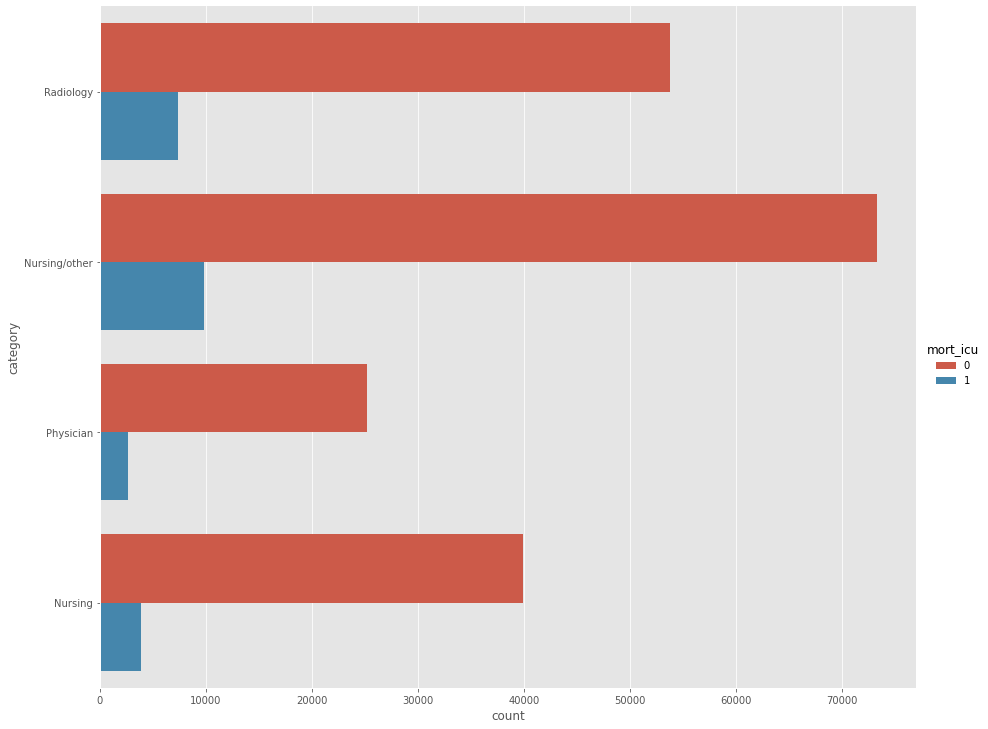

time: 5.54 s


In [11]:
g = sns.catplot(y='category', hue='mort_icu', kind='count', data=filtered_notes, height=10, aspect=1.3)
#g.text('Radiology','0', 100, color='black', ha="center")
plt.savefig('note_mortality.png', dpi=500)

In [12]:
pivoted_notes = filtered_notes.pivot_table(index=['subject_id', 'icu_time_hr'], columns='category', values='text', aggfunc=lambda t : '\n'.join(t))
pivoted_notes.loc[pivoted_notes['Nursing/other'] == '','Nursing/other'] = pivoted_notes[pivoted_notes['Nursing/other'] == '']['Nursing']
pivoted_notes.fillna('', inplace=True)

time: 2.05 s


In [13]:
print(len(pivoted_notes))
pivoted_notes.head(20)

150097


category               Nursing  ...                                          Radiology
subject_id icu_time_hr          ...                                                   
3          3.0                  ...  [**2101-10-20**] 10:23 PM CHEST (PORTABLE AP) ...
           6.0                  ...  [**2101-10-21**] 1:00 AM CHEST (PORTABLE AP) C...
           11.0                 ...  [**2101-10-21**] 6:10 AM CHEST (PORTABLE AP) C...
           12.0                 ...                                                   
           19.0                 ...                                                   
           22.0                 ...  [**2101-10-21**] 4:43 PM CHEST (PORTABLE AP) C...
           26.0                 ...                                                   
           27.0                 ...                                                   
           33.0                 ...                                                   
           35.0                 ...                                                   
           45.0                 ...  [**2101-10-22**] 4:27 PM CHEST (PORTABLE AP) C...
           47.0                 ...                                                   
6          7.0                  ...                                                   
           14.0                 ...  [**2175-5-31**] 11:03 AM RENAL TRANSPLANT U.S....
           20.0                 ...                                                   
           30.0                 ...                                                   
           44.0                 ...                                                   
9          3.0                  ...                                                   
           5.0                  ...                                                   
           16.0                 ...                                                   

[20 rows x 4 columns]

time: 25.4 ms


In [ ]:
print(pivoted_notes.loc[3].iloc[0]['Radiology'])

In [15]:
pivoted_notes_v2 = filtered_notes.pivot_table(index='subject_id', columns='category', values='text', aggfunc=lambda t : '\n'.join(t))
pivoted_notes_v2.loc[pivoted_notes_v2['Nursing/other'].isnull(),'Nursing/other'] = pivoted_notes_v2[pivoted_notes_v2['Nursing/other'].isnull()]['Nursing']
#pivoted_notes_v2.fillna('', inplace=True)
pivoted_notes_v2.dropna(axis=0, subset=['Nursing/other'], inplace=True)
print(len(pivoted_notes_v2))
pivoted_notes_v2.head(20)

16970


category,Nursing,Nursing/other,Physician,Radiology
subject_id,,,,
3,NaN,Micu Progress Nursing Note: Patient arrived un...,NaN,[**2101-10-20**] 10:23 PM CHEST (PORTABLE AP) ...
6,NaN,2230-0700 Recieved pt PACU following LR kidney...,NaN,[**2175-5-31**] 11:03 AM RENAL TRANSPLANT U.S....
9,NaN,Respiratory Care: Pt. intubated EW airway prot...,NaN,[**2149-11-10**] 11:07 AM CT HEAD W/O CONTRAST...
12,NaN,Respiratory Care: Patient admitted OR intubate...,NaN,NaN
13,NaN,CCU ADMISSION NPN 1900-0700: LEFT MAIN HPI: IN...,NaN,[**2167-1-9**] 6:11 AM CHEST (PORTABLE AP) Cli...
17,NaN,OP DAY MINIMALLY INVASIVE PFO REPAIR NSR. NO E...,NaN,NaN
21,NaN,"ADMISSION NOTE 87 YR OLD MAN WITH H/O CAD, CVA...",NaN,[**2134-9-12**] 10:48 AM CHEST (PORTABLE AP) C...
25,NaN,NURSING PROGRESS NOTE 58 Y/O MALE ADMITTED FRO...,NaN,NaN
26,NaN,"Nsg Progress Note Pt 72 yo man known CAD, S/P ...",NaN,[**2126-5-9**] 8:03 AM CHEST (PORTABLE AP) Cli...


time: 864 ms


In [ ]:
print(pivoted_notes_v2.loc[3]['Nursing/other'])

In [17]:
mortality = filtered_notes[['subject_id','mort_icu']].drop_duplicates(subset=['subject_id'])
mortality = mortality[mortality.subject_id.isin(pivoted_notes_v2.index.values)][['mort_icu']].values
mortality.shape

(16970, 1)

time: 20.7 ms


In [18]:
vocab_size = 100000
note_category = 'Nursing/other'
vocab = np.unique(np.concatenate(pivoted_notes_v2[[note_category]].values))
print(vocab.shape)
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(vocab)
notes_sequences = tokenizer.texts_to_sequences(pivoted_notes_v2[note_category].values)


(16970,)
time: 22.3 s


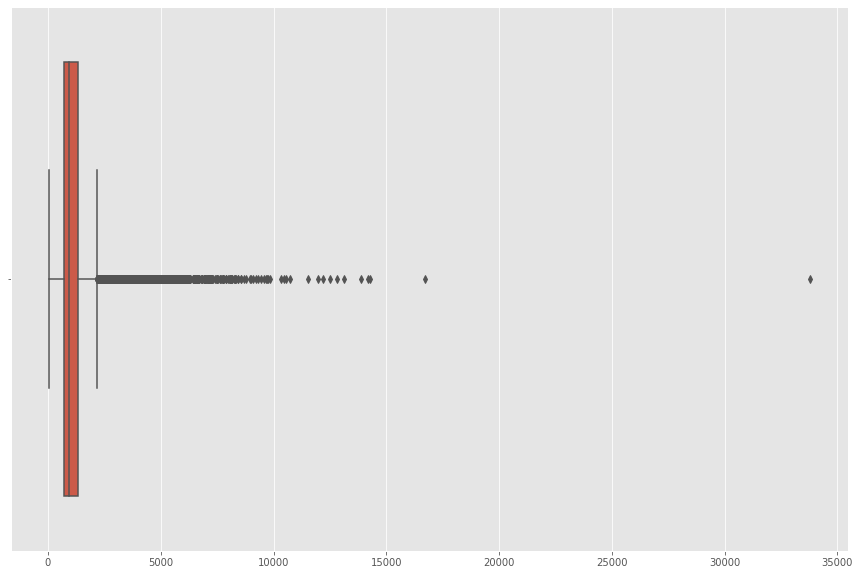

time: 5.5 s


In [19]:
plt.figure(figsize=(15,10))
sns.boxplot([len(x) for x in notes_sequences])
plt.savefig('note-length-box-plot.png', dpi=500)

In [20]:
sequence_max_length = 500
padded_notes_sequences = pad_sequences(notes_sequences, sequence_max_length, truncating='pre')
print(f'Total words: {len(tokenizer.word_index) + 1}')

Total words: 111687
time: 712 ms


In [21]:
embedding_dimension = 10

def create_model(output_bias=None):

  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)

  notes_shape = (sequence_max_length, )
  notes_input = tf.keras.layers.Input(shape=notes_shape, name='notes')
  dense_vectors = tf.keras.layers.Embedding(input_dim=vocab_size + 1, 
                                            output_dim=embedding_dimension, 
                                            input_length=sequence_max_length)(notes_input)

  notes_embeddings = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100,
                                                                        dropout=0.5,
                                                                        return_sequences=True),
                                                    name='bidirectional_lstm')(dense_vectors)
  notes_embeddings = tf.keras.layers.LSTM(100, dropout=0.5, name='lstm')(notes_embeddings)

  notes_embeddings = tf.keras.layers.Dropout(0.5, name = 'dropout')(notes_embeddings)
  fc1 = tf.keras.layers.Dense(50, 
                              activation='relu', 
                              kernel_initializer='he_normal',
                              name='fc1')(notes_embeddings)

  mortality = tf.keras.layers.Dense(1, 
                                    activation='sigmoid',
                                    kernel_initializer='he_normal',
                                    bias_initializer=output_bias,
                                    name='mortality')(fc1)

  return tf.keras.Model(inputs=notes_input, outputs=mortality)


def create_model_conv(output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  notes_shape = (sequence_max_length, )
  notes_input = tf.keras.layers.Input(shape=notes_shape, name='notes')

  dense_vectors = tf.keras.layers.Embedding(input_dim=vocab_size + 1, 
                                            output_dim=embedding_dimension, 
                                            input_length=sequence_max_length)(notes_input)
  
  dense_vectors = tf.keras.backend.expand_dims(dense_vectors, axis=3)

  notes_embeddings = tf.keras.layers.Conv2D(32, (5, embedding_dimension), activation='relu', padding='same')(dense_vectors)

  notes_embeddings = tf.keras.layers.MaxPool2D(pool_size = (1,3), padding = 'same')(notes_embeddings)

  notes_embeddings = tf.keras.layers.Flatten()(notes_embeddings)

  fc1 = tf.keras.layers.Dense(50, 
                              activation='relu', 
                              kernel_initializer='he_normal',
                              name='fc1')(notes_embeddings)

  mortality = tf.keras.layers.Dense(1, 
                                    activation='sigmoid',
                                    kernel_initializer='he_normal',
                                    bias_initializer=output_bias,
                                    name='mortality')(fc1)

  return tf.keras.Model(inputs=notes_input, outputs=mortality)

time: 38.9 ms


In [22]:
import re
import os
import shutil
def get_best_val_model(fold):
  filenames = [f for f in os.listdir(
          "./") if f.startswith(f"kfold{fold}_") and f.endswith(".h5")]

  metric_values_str = [re.findall('0.[0-9]+',f) for f in filenames]
  best_model_filename = filenames[np.argmax([get_F1(float(m[0]), float(m[1])) for m in metric_values_str])]
  print(best_model_filename)
  shutil.copy(best_model_filename, f'kfold{fold}_best_F1.h5')
  return tf.keras.models.load_model(best_model_filename)

def get_F1(precision, recall):
  try:
    return 2 * (precision * recall) / (precision + recall)
  except ZeroDivisionError:
    return 0

time: 8.89 ms


In [23]:
X = padded_notes_sequences
y = mortality

cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
cv_idx = list(cv.split(X=np.zeros(X.shape[0]), y=y))

time: 8.13 ms


In [24]:
import pickle
from sklearn.model_selection import train_test_split, StratifiedKFold


total = y.shape[0]
pos = y.sum()
neg = total - pos

num_epochs = 3
batch_size = 128
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

#history = model.fit(padded_notes_sequences, mortality, epochs=num_epochs, batch_size = batch_size, class_weight=class_weight)

predictions = []
predictions_training_set = []
ground_truth = []
ground_truth_training_set = []
fold_history = []


initial_bias = np.log([pos/neg])


i = 0
for train, validation in cv_idx:
    tf.keras.backend.clear_session()
    ground_truth_training_set.append(y[train])
    ground_truth.append(y[validation])
    print(f'Fold {i}. Positive examples in validation: {np.sum(y[validation])}...')
    model = create_model_conv(output_bias=initial_bias)
    #sgd = tf.keras.optimizers.SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=True)
    model.compile(optimizer = 'adam', 
                  loss = 'binary_crossentropy', 
                  metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
    
    #checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filepath=f'kfold{i}.h5', 
    #                                                   monitor='val_accuracy', save_best_only=True)
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filepath=f"kfold{i}_" + "precision_{val_precision:.5f}_recall_{val_recall:.5f}_loss_{val_loss:.5f}.h5",
                                            monitor='val_loss')
    fold_history.append(model.fit(x = X[train], y = y[train], 
                                  epochs = num_epochs, batch_size = batch_size, 
                                  class_weight=class_weight,
                                  callbacks=[checkpoint_cb],
                                  validation_data=(X[validation], 
                                                   y[validation])))
    
    
    model = get_best_val_model(i)
    predictions_training_set.append(model.predict(X[train]))
    predictions.append(model.predict(X[validation]))
    i += 1


Weight for class 0: 0.55
Weight for class 1: 5.11
Fold 0. Positive examples in validation: 331...
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 13576 samples, validate on 3394 samples
Epoch 1/3
13576/13576 [==============================] - 9s 699us/sample - loss: 0.6473 - recall: 0.6370 - precision: 0.1732 - val_loss: 0.5102 - val_recall: 0.8792 - val_precision: 0.2188
Epoch 2/3
13576/13576 [==============================] - 2s 173us/sample - loss: 0.4417 - recall: 0.8404 - precision: 0.3068 - val_loss: 0.4672 - val_recall: 0.8580 - val_precision: 0.2700
Epoch 3/3
13576/13576 [==============================] - 2s 165us/sample - loss: 0.3392 - recall: 0.9081 - precision: 0.4110 - val_loss: 0.4743 - val_recall: 0.7281 - val_precision: 0.2869
kfold0_precision_0.28690_recall_0.72810_loss_0.47434.h5
Fold 1. Positive examples in validation: 332...
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 13576 samples, validate on 3394 samples
Epoch 1/3
13576/13576 [==========

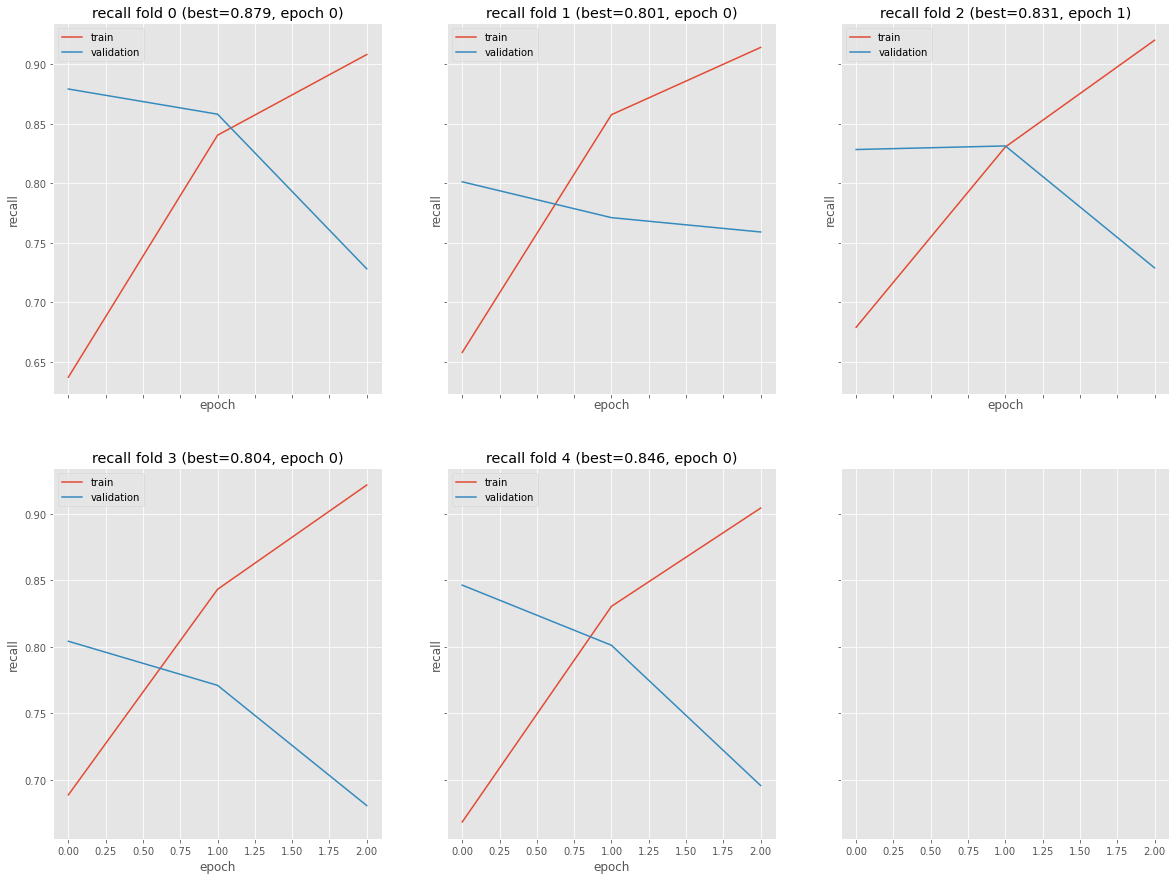

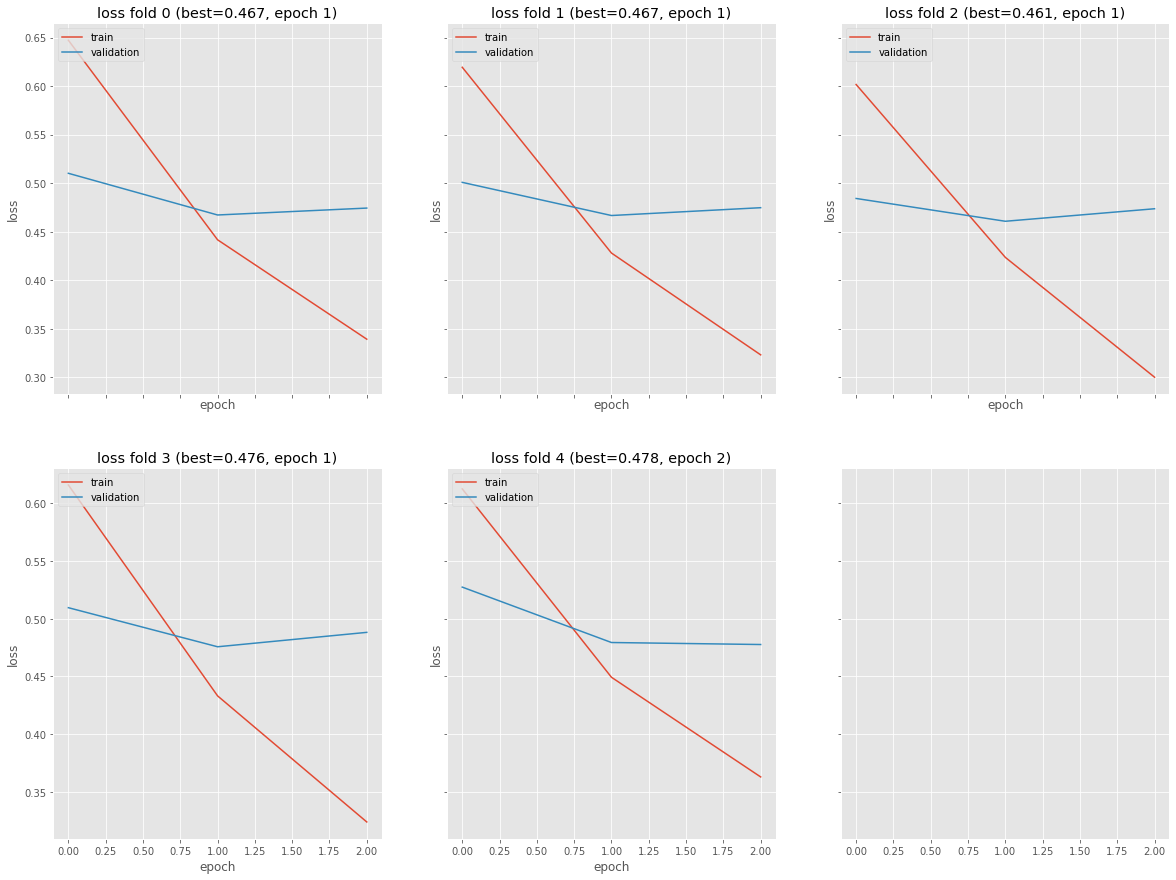

time: 24.1 s


In [25]:
def plot_history(metric='accuracy'):
  fig, ax = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(20,15))
  for k, history in enumerate(fold_history):
      f = np.argmax
      if metric == 'loss':
        f = np.argmin
      j = f(history.history[f'val_{metric}'])
      
      ax[int(k // 3), k % 3].plot(history.history[metric])
      ax[int(k // 3), k % 3].plot(history.history[f'val_{metric}'])
      ax[int(k // 3), k % 3].set_title('{3} fold {0} (best={1:.3f}, epoch {2})'.format(k, history.history[f'val_{metric}'][j], j, metric))
      ax[int(k // 3), k % 3].set_ylabel(metric)
      ax[int(k // 3), k % 3].set_xlabel('epoch')
      ax[int(k // 3), k % 3].legend(['train', 'validation'], loc='upper left')
  plt.savefig(f'{metric}_history.png', dpi=500)
  plt.show()
  
plot_history('recall')
plot_history('loss')

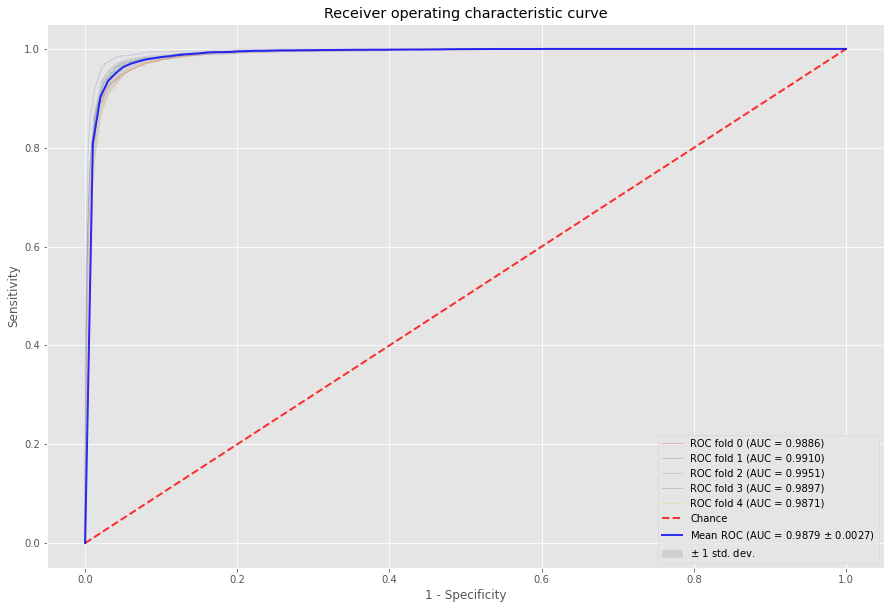

time: 5.69 s


In [26]:
 #plot_roc_curve(mortality, predictions)
 _ = cross_validation_plot_roc_curve(ground_truth_training_set, predictions_training_set,
                               filename='roc_curve_training.png')

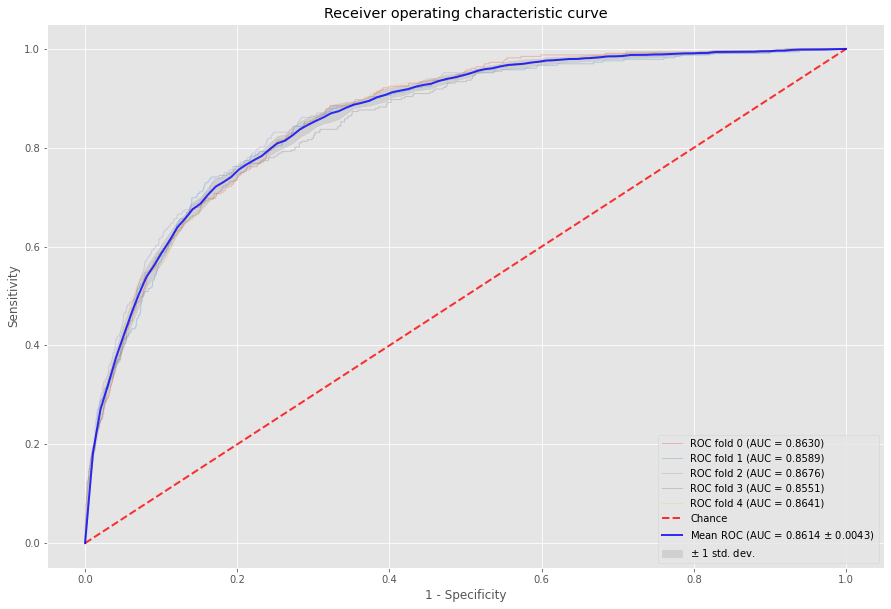

time: 5.75 s


In [27]:
roc_aucs = cross_validation_plot_roc_curve(ground_truth, predictions, 
                                filename='roc_curve_validation.png')

In [28]:
import scipy.stats as st
st.t.interval(0.95, len(roc_aucs)-1, loc=np.mean(roc_aucs), scale=st.sem(roc_aucs))

(0.8557360651199797, 0.8677330373972616)

time: 5.64 ms


In [29]:
import tensorflow
from tensorflow.compat.v1.keras.backend import get_session
tensorflow.compat.v1.disable_v2_behavior()
train = cv_idx[0][0]
background = X[train][np.random.choice(X[train].shape[0], 50, replace=False)]
model = tf.keras.models.load_model('kfold0_best_F1.h5')
# explain predictions of the model
e = shap.DeepExplainer(model, background)

Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

time: 1.08 s


Using TensorFlow backend.
keras is no longer supported, please use tf.keras instead.


In [30]:
patient_idx = 541
shap_values = e.shap_values(X[train][patient_idx:patient_idx+1])
#print(shap_values[0][0])

time: 632 ms


In [31]:
print(np.sum(shap_values[0][0]))
sum_positives = np.sum(shap_values[0][shap_values[0] > 0])
sum_negatives = np.sum(shap_values[0][shap_values[0] <= 0])
normalized_positive_shapley_values = shap_values[0][0]/sum_positives
normalized_negative_shapley_values = shap_values[0][0]/sum_negatives

-0.16663782049237222
time: 3.43 ms


In [32]:
word_index = tokenizer.word_index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
words = [reverse_word_index.get(i, '*') for i in X[train][patient_idx]]
death_words_importance = {k:v for (k,v) in zip(words, shap_values[0][0]) if v > 0}
survival_words_importance = {k:v*-1 for (k,v) in zip(words, shap_values[0][0]) if v < 0}

time: 56.2 ms


In [33]:
import matplotlib as mpl
import matplotlib.cm as cm
# set the colormap and centre the colorbar
# http://chris35wills.github.io/matplotlib_diverging_colorbar/
class MidpointNormalize(mpl.colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)
    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))


from IPython.core.display import HTML
def create_note_importance_viz(words, heatmap_colors):
  text="<p style='font-size:17px;width:1000px'>"
  for w, c in  zip(words, heatmap_colors):
    #if w is not '?':
    text += f"<span style='background-color: rgba({','.join([str(int(v*255)) for v in c[:-1]])}, 0.7)'>{w}</span> "
  text += '</p>'
  return text

time: 12.3 ms


In [34]:
wc_death = WordCloud(background_color="white", max_words=100, width=1500, height=1500, colormap='cubehelix')
wc_survival = WordCloud(background_color="white", max_words=100, width=1500, height=1500, colormap='cubehelix')
# generate word cloud
wc_death.generate_from_frequencies(death_words_importance)
wc_survival.generate_from_frequencies(survival_words_importance)

time: 10.7 s


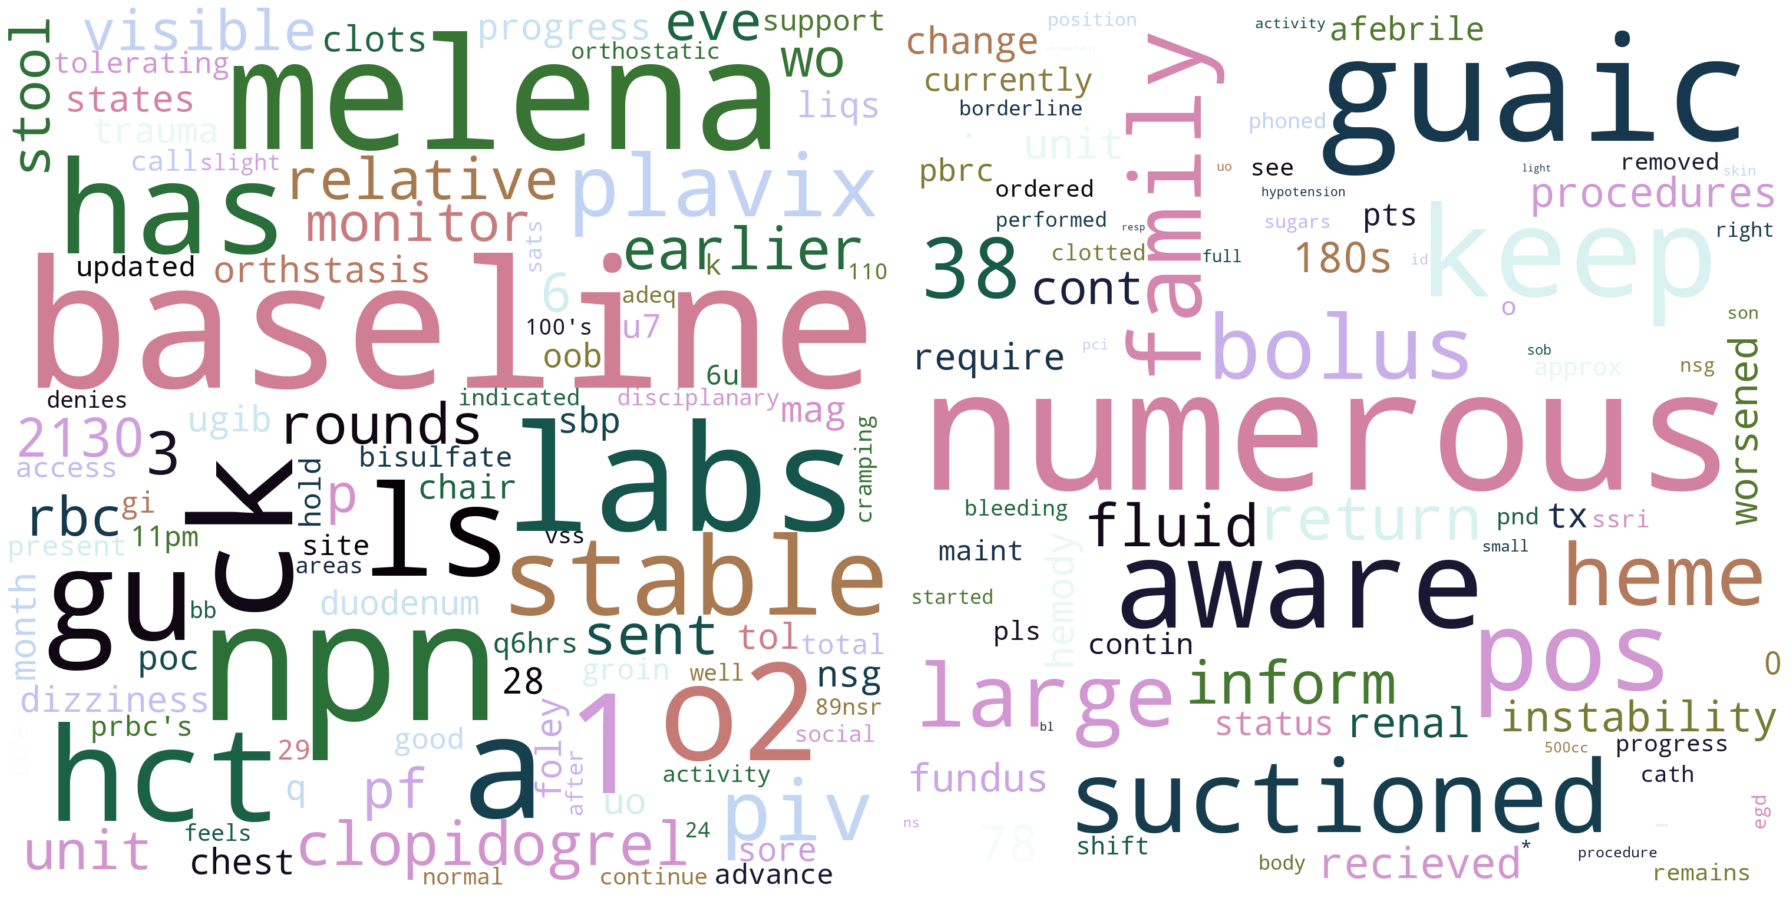

time: 23.3 s


In [35]:
fig, ax = plt.subplots(1, 2, figsize=(25,15))
ax[0].imshow(wc_survival, interpolation="bilinear")
ax[1].imshow(wc_death, interpolation="bilinear")
ax[0].axis("off") 
ax[1].axis("off")
plt.tight_layout()
plt.savefig("wordclouds.png", dpi=500)
plt.show()

In [36]:
cmap='coolwarm'
norm = MidpointNormalize(vmin=shap_values[0][0].min(), vmax=shap_values[0][0].max(), midpoint=0)
scaled_scores = norm(shap_values[0][0])
heatmap_cm = cm.get_cmap(cmap)

heatmap_colors = heatmap_cm(scaled_scores)
html = create_note_importance_viz(words, heatmap_colors)
HTML(html)

time: 9.85 ms


In [37]:
from scipy.ndimage import convolve1d, gaussian_filter1d
convolved_scores = convolve1d(shap_values[0][0], weights=[0.1, 0.2, 0.4, 0.2, 0.1])
#convolved_scores = gaussian_filter1d(shap_values[0][0], sigma=0.7)
scaled_scores = norm(convolved_scores)
heatmap_colors = heatmap_cm(scaled_scores)
html = create_note_importance_viz(words, heatmap_colors)
HTML(html)

time: 8.3 ms


In [40]:
total = y.shape[0]
pos = y.sum()
neg = total - pos
print(total, pos, neg)

16970 1659 15311
time: 1.73 ms


In [41]:
pd.DataFrame([len(x) for x in notes_sequences]).describe()

,0
count,16970.000000
mean,1252.595875
std,1087.483645
min,34.000000
25%,724.000000
50%,952.000000
75%,1310.000000
max,33771.000000


time: 27.9 ms


In [42]:
pivoted_notes_v2

category,Nursing,Nursing/other,Physician,Radiology
subject_id,,,,
3,NaN,Micu Progress Nursing Note: Patient arrived un...,NaN,[**2101-10-20**] 10:23 PM CHEST (PORTABLE AP) ...
6,NaN,2230-0700 Recieved pt PACU following LR kidney...,NaN,[**2175-5-31**] 11:03 AM RENAL TRANSPLANT U.S....
9,NaN,Respiratory Care: Pt. intubated EW airway prot...,NaN,[**2149-11-10**] 11:07 AM CT HEAD W/O CONTRAST...
12,NaN,Respiratory Care: Patient admitted OR intubate...,NaN,NaN
13,NaN,CCU ADMISSION NPN 1900-0700: LEFT MAIN HPI: IN...,NaN,[**2167-1-9**] 6:11 AM CHEST (PORTABLE AP) Cli...
...,...,...,...,...
99944,".H/O heart failure (CHF), Diastolic, Chronic A...",".H/O heart failure (CHF), Diastolic, Chronic A...",TITLE: Physician Resident Admission Note Chief...,[**2161-2-18**] 6:33 AM CHEST (PORTABLE AP) Cl...
99957,68 year old male admitted [**Hospital 1115**] ...,68 year old male admitted [**Hospital 1115**] ...,TITLE: Chief Complaint: OSH transfer cerebriti...,[**2157-2-21**] 12:43 AM CHEST PORT. LINE PLAC...
99973,"65 y/o female hypotension,C-Diff Diarrhea/decr...","65 y/o female hypotension,C-Diff Diarrhea/decr...",Chief Complaint: hypotension/diarrhea HPI: Thi...,[**2180-11-27**] 11:52 AM CHEST (PORTABLE AP) ...


time: 47.3 ms


In [43]:
mortality_2 = filtered_notes[['subject_id', 'los','mort_icu']].drop_duplicates(subset=['subject_id'])
#mortality_2 = filtered_notes[['subject_id', 'age', 'los','mort_icu']].drop_duplicates(subset=['subject_id'])
mortality_2 = mortality_2[mortality_2.subject_id.isin(pivoted_notes_v2.index.values)].set_index('subject_id')
mortality_2[mortality_2.mort_icu == 0].head()

,los,mort_icu
subject_id,,
3,6.0646,0
6,3.6729,0
12,7.6348,0
13,3.6660,0
17,2.0710,0


time: 34.5 ms


In [44]:
mortality_2.describe()

,los,mort_icu
count,16970.000000,16970.000000
mean,6.733514,0.097761
std,7.626483,0.297000
min,2.000000,0.000000
25%,2.764350,0.000000
50%,3.962450,0.000000
75%,7.155525,0.000000
max,153.928000,1.000000


time: 24 ms


In [45]:
#mortality_2[mortality_2.mort_icu == 0][['age', 'los']].describe()

time: 776 µs


In [46]:
#mortality_2[mortality_2.mort_icu == 1][['age', 'los']].describe()

time: 600 µs


In [47]:
all_data = pivoted_notes_v2.join(mortality_2)

time: 22.1 ms


In [48]:
#plt.figure(figsize=(15,10))

#ax = sns.distplot(all_data[all_data.mort_icu == 0].age, kde=False, hist_kws=dict(edgecolor="k", linewidth=2), label='Survival')
#sns.distplot(all_data[all_data.mort_icu == 1].age, kde=False, hist_kws=dict(edgecolor="k", linewidth=2), label='Death')
#ax.set(xlabel='Age', ylabel='Count')
#plt.legend()
#plt.tight_layout()
#plt.savefig('age-hist.png', dpi=500)
#plt.show()

time: 992 µs


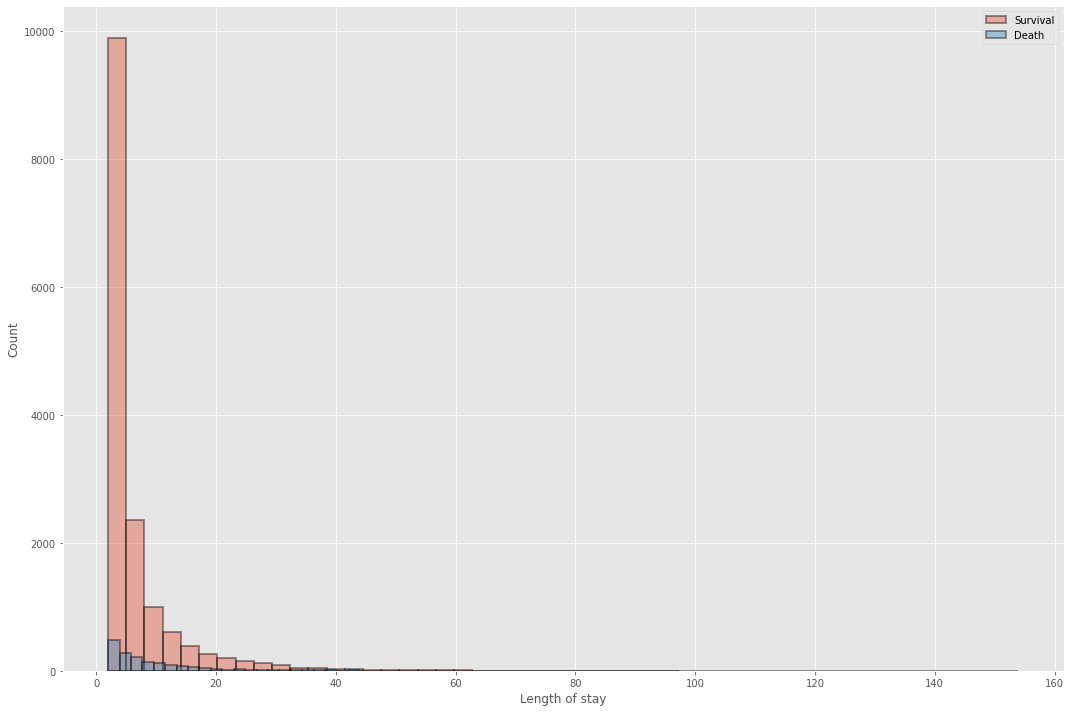

time: 5.85 s


In [49]:
plt.figure(figsize=(15,10))

ax = sns.distplot(all_data[all_data.mort_icu == 0].los, kde=False, hist_kws=dict(edgecolor="k", linewidth=2), label='Survival')
sns.distplot(all_data[all_data.mort_icu == 1].los, kde=False, hist_kws=dict(edgecolor="k", linewidth=2), label='Death')
ax.set(xlabel='Length of stay', ylabel='Count')
plt.legend()
plt.tight_layout()
plt.savefig('LoS-hist.png', dpi=500)
plt.show()

In [50]:
vocab_size = 100000
note_category = 'Nursing/other'
vocab = np.unique(np.concatenate(all_data[[note_category]].values))

oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(vocab)
notes_sequences = tokenizer.texts_to_sequences(all_data[note_category][all_data.mort_icu==0].values)
notes_sequences_2 = tokenizer.texts_to_sequences(all_data[note_category][all_data.mort_icu==1].values)

time: 22.4 s


In [51]:
vocab.shape

(16970,)

time: 2.38 ms


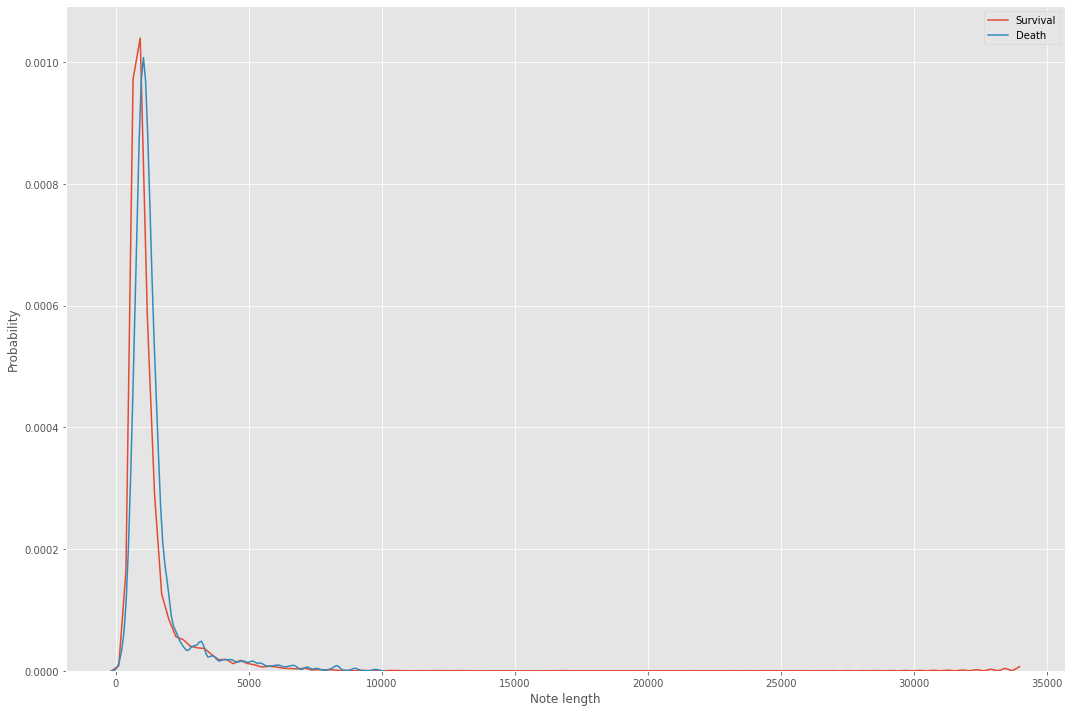

time: 4.91 s


In [52]:
plt.figure(figsize=(15,10))
#sns.boxplot([len(x) for x in notes_sequences])
#sns.boxplot([len(x) for x in notes_sequences_2])
survival_lengths = pd.DataFrame(data={'Note length': [len(x) for x in notes_sequences]})
#survival_lengths['Class'] = 'Survival'
death_lengths = pd.DataFrame(data={'Note length': [len(x) for x in notes_sequences_2]})
#death_lengths['Class'] = 'Death'
#all_sequences = survival_lengths.append(death_lengths)
#sns.boxplot(data=all_sequences, x='Class', y='Length')
ax = sns.kdeplot([len(x) for x in notes_sequences], label='Survival')
ax.set(xlabel='Note length', ylabel='Probability')
sns.kdeplot([len(x) for x in notes_sequences_2], label='Death')
plt.legend()
plt.tight_layout()
plt.savefig('note-length-dist-plot-by-class.png', dpi=500)

In [53]:
pd.DataFrame([len(x) for x in notes_sequences]).describe()

,0
count,15311.000000
mean,1233.303442
std,1083.033294
min,34.000000
25%,711.000000
50%,934.000000
75%,1286.000000
max,33771.000000


time: 25.8 ms


In [54]:
pd.DataFrame([len(x) for x in notes_sequences_2]).describe()

,0
count,1659.000000
mean,1430.646775
std,1112.372319
min,144.000000
25%,890.000000
50%,1135.000000
75%,1492.000000
max,9756.000000


time: 19.1 ms


In [55]:
from scipy.stats import mannwhitneyu
mannwhitneyu(x=[len(x) for x in notes_sequences], y=[len(x) for x in notes_sequences_2], alternative='less')


MannwhitneyuResult(statistic=9682267.5, pvalue=2.1481130284001697e-57)

time: 11.1 ms


In [56]:
from statsmodels.graphics.gofplots import qqplot_2samples


time: 114 ms


In [57]:
np.random.seed(1)
pt_idx = np.random.randint(X[validation].shape[0], size=10)
all_shap_values = e.shap_values(X[validation][pt_idx])

time: 124 ms


In [58]:
print(pt_idx)
print(np.array(all_shap_values).shape)

[1061  235 1096  905 2763 2895  960  144  129 2797]
(1, 10, 500)
time: 1.64 ms


In [59]:
word_index = tokenizer.word_index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
def get_viz_data(k, shap_values, convolve=False):
  words = [reverse_word_index.get(i, '*') for i in X[validation][pt_idx[k]]]
  scores = shap_values[0][k]
  norm = MidpointNormalize(vmin=scores.min(), vmax=scores.max(), midpoint=0)
  if convolve:
    scores = convolve1d(scores, weights=[0.1, 0.2, 0.4, 0.2, 0.1])
  scaled_scores = norm(scores)
  heatmap_cm = cm.get_cmap(cmap)
  heatmap_colors = heatmap_cm(scaled_scores)
  return words, heatmap_colors

time: 59.7 ms


In [ ]:
k = 1
words, heatmap_colors = get_viz_data(k, all_shap_values, convolve=True)
html = create_note_importance_viz(words, heatmap_colors)
HTML(html)

In [ ]:
k = 2
words, heatmap_colors = get_viz_data(k, all_shap_values, convolve=True)
html = create_note_importance_viz(words, heatmap_colors)
HTML(html)

In [ ]:
k = 6
words, heatmap_colors = get_viz_data(k, all_shap_values, convolve=True)
html = create_note_importance_viz(words, heatmap_colors)
HTML(html)

In [ ]:
k = 7
words, heatmap_colors = get_viz_data(k, all_shap_values, convolve=False)
html = create_note_importance_viz(words, heatmap_colors)
HTML(html)

In [67]:
np.random.seed(1)
all_shap_values = []
for i in range(5):
  #pt_idx = np.random.randint(X[cv_idx[i][1]].shape[0], size=1000)
  all_shap_values.append(e.shap_values(X[cv_idx[i][1]])[0][np.where(X[cv_idx[i][1]] == 0)])

time: 2min 57s


In [70]:
scores = np.array([])
for i in range(5):
  scores = np.append(scores, all_shap_values[i])

time: 7.16 ms


In [71]:
pd.DataFrame(scores).describe()

,0
count,106326.000000
mean,-0.000300
std,0.000364
min,-0.003096
25%,-0.000447
50%,-0.000227
75%,-0.000058
max,0.000649


time: 21.7 ms


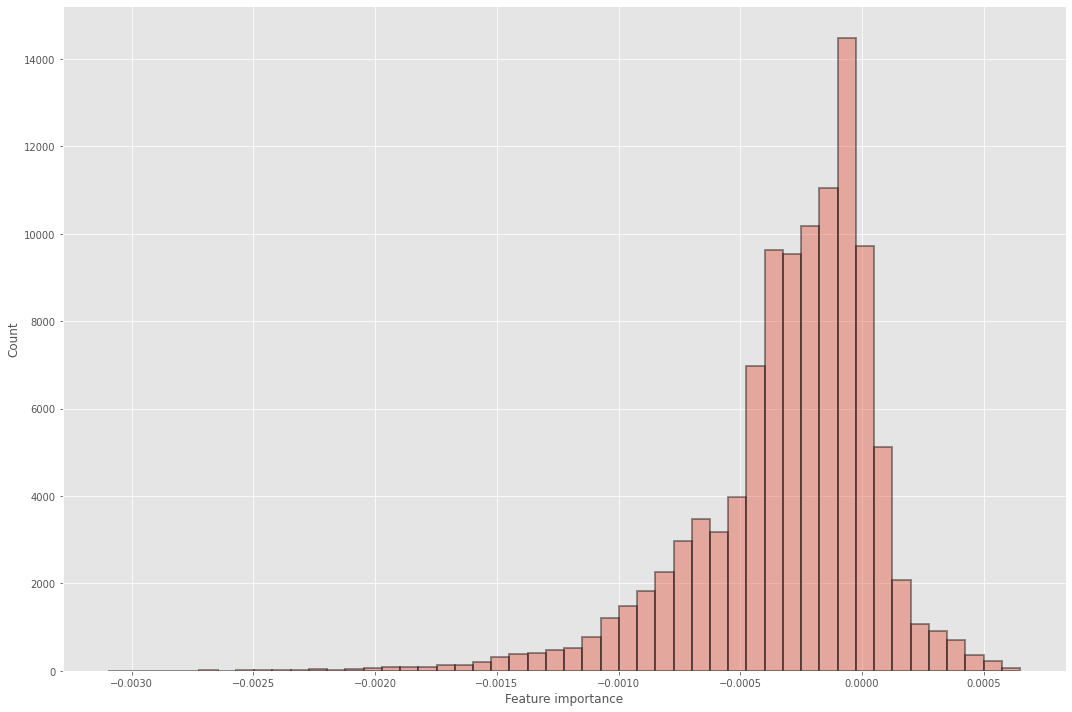

time: 5.81 s


In [72]:
plt.figure(figsize=(15,10))
ax = sns.distplot(scores, kde=False, hist_kws=dict(edgecolor="k", linewidth=2))
ax.set(xlabel='Feature importance', ylabel='Count')
plt.tight_layout()
plt.savefig('padding-chars-importance-hist.png', dpi=500)
plt.show()


In [73]:
np.setdiff1d(cv_idx[4][1],validation)

array([], dtype=int64)

time: 4.09 ms


In [74]:
sapsii_valid_preds = filtered_notes[['subject_id', 'sapsii_prob', 'mort_icu']].drop_duplicates(subset=['subject_id'])[['subject_id', 'sapsii_prob', 'mort_icu']]
sapsii_valid_preds = sapsii_valid_preds[sapsii_valid_preds.subject_id.isin(pivoted_notes_v2.index.values)]
sapsii_valid_preds.shape

(16970, 3)

time: 20.9 ms


In [75]:
roc_aucs = []
gt = []
preds = []
for train, validation in cv_idx:
    gt.append(sapsii_valid_preds['mort_icu'].values[validation])
    preds.append(sapsii_valid_preds['sapsii_prob'].values[validation])
    fpr, tpr, thr= roc_curve(y_true=sapsii_valid_preds['mort_icu'].values[validation], y_score=sapsii_valid_preds['sapsii_prob'].values[validation], drop_intermediate=False)
    roc_aucs.append(auc(fpr, tpr))
print(roc_aucs)
print(np.array(roc_aucs).mean())
print(np.array(roc_aucs).std())

[0.7358877470402514, 0.7483370779001046, 0.7626811950611067, 0.7488028534779222, 0.7288246716454321]
0.7449067090249634
0.011686345259534598
time: 13.1 ms


In [76]:
st.t.interval(0.95, len(roc_aucs)-1, loc=np.mean(roc_aucs), scale=st.sem(roc_aucs))

(0.7286834609782202, 0.7611299570717065)

time: 4.64 ms


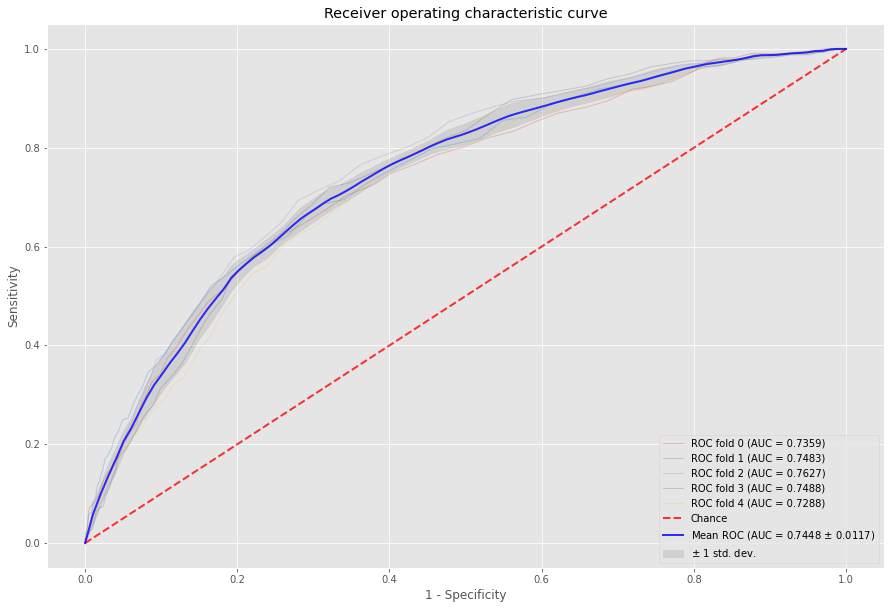

[0.7358877470402514,
 0.7483370779001046,
 0.7626811950611067,
 0.7488028534779222,
 0.7288246716454321]

time: 5.81 s


In [77]:
cross_validation_plot_roc_curve(gt, preds, "SAPS-II validation ROC")